In [1]:
#----------------------------------------------------------------
# Voice Calls
# +Voice Capture and Sampling
# - Microphone converts the speakers voice into analog electrical signals
# - The analog voice is sampled and digitized into packets
# - The voice data is compressed to optimize bandwidth usage
# - For Circuit - Switched networks (eg GSM) - a specific frequency or time slot is reserved for the duration of the call
# - For Packet switched networks (VoIP) - voice packets are routed dynamically over shared channels
# - Forward Error Correct (FEC) ensure reliable transmission over noisy channels
# +Transmision
# - The digital packets travel over the channel ( radio frequency, fiber-optic etc)
# +Reception
# - The receiver decodes the packets, reconstructing the original voice signal
# - The decoded voice data is converted to sound by receiver's speaker
# 
#
#
# Data communication (Internet, SMS etc)
# +Packet formation
# - a message is broken into packets
# - each packet contains: HEADER (destination address, sequence number etc), PAYLOAD (data content), checksum (to verify integrity)
# +Tansmission
# - a channel is assigned dynamically: 
#       ~TDMA ( Time Division Multiple Access - allocates specific time slots to each user)
#       ~FDMA ( Frequency Division Multiple Access - allocates different frequency bands for each user)
#       ~CDMA ( Code Division Multiple Access - shares the same frequency band with unique codes for users)
# - The packets are sent through the network (fiber-optic, wireless, frequencies etc)
# - Checksums or other methods for error correction - ensures that corrupted packets are identified and retransmitted
# +Reception
# - Receiver reassembles the packets in the correct order - based on the sequence numbers in the headers 
# - Data integrity is checked (using checksum)
# - The payload is extracted an presented to the user (displaying a webpage or opening a file etc)
#
# TETRA - Terrestrial Trunked Radio
# - designed mainly for voice communication, but can also be used for data communication
# 
# Example:
# - Alisa calls Marius and Andrei - to discuss our secret plan to protect the Candy Factory against Minons that would invade on Christmas Day
# - Alisa is connected to a local Tetra network
# - Marius and Andrei are connected to another Tetra network
# - Objective_1 - The communication must be encrypted to prevent the Minions from eavesdropping (using TETRA)
# - Objective_2 (topic of our project) - choose the best TETRA channel (frequency + time slot) for our group call
# - Steps:
#       ~ Alisa dials Marius and Andreis numbers from her TETRA terminal
#       ~ The terminal sends a call request to the nearest TETRA base station
#       ~ The base station forwards the request to the TETRA Switching and Management Infrastructure to process the call
#       ~ The SwMI ensures that I am authenticated and authorized to make the call
#       ~ SwMI identifies the group members (Marius and Andrei) based on the dialed numbers
#       ~ SwMI sends a paging signal to Marius and Andrei's TETRA terminals to alert them on an incoming group call
# - Using FDMA 
#       ~The TETRA network assigns a 25 kHz frequency channel with one or more time slots for the calls
# - The selection depends on the current network load and interference levels in our areas
# - Using TDMA
#       ~On the selected frequency, a time slot is allocated for the call
# - A common control channel handles signaling during the call setup to manage resources and confirm the allocation
# - The network dynamically allocates channels to ensure efficient use of the spectrum
# - If traffic is high in the locations, TETRA system may reuse frequencies that are far enough apart to avoid interference
#
# Quantum approach:
# - Objective_2 - choose the best TETRA channel (frequency + time slot) for our group call
# - Define a set of available TETRA channels
# - Signal to Noise Ratio (SNR) - Measure the channels clarity
# - Interference Level: measures how much cross talk exists on the channel
# - Latency: Measure Time delay
# - Best Channel: minimal interference and latency + maximize SNR for optimal clarity and reliability
#-----------------------------------------------------------------

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
import numpy as np
import random
import math
import pandas as pd
import csv
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram




# Constants
#-----------------------------------------------------------------
# Set bandwidth at 25 khz - as per the standard definition of TETRA radio channel bandwidth 
# Source: https://www.telecomabc.com/t/tetra.html#:~:text=The%20TETRA%20radio%20standard%20is,a%20bandwidth%20of%2025%20kHz.
#-----------------------------------------------------------------
bandwidth = 25e3  # Bandwidth (TETRA standard) - 25000 Hz

#-----------------------------------------------------------------
# Initialize variable with the available Channels and corresponding SNRs, from a file
#-----------------------------------------------------------------
data = pd.read_csv('channels_snr.csv')
available_channels = data['Channel'].tolist()
measured_snr = data['SNR'].tolist()

print(available_channels)
print(measured_snr)


#-----------------------------------------------------------------
# Define the list of dictioneries of the Channels and their corresponding SNR
#-----------------------------------------------------------------
channels = [
            {
                'id': f'ch{i+1}',                  # Channel identifier
                'channel_code': available_channels[i],  # Channel code retrived from available_channels
                'snr': measured_snr[i],           # Signal-to-Noise Ratio (SNR) from measured_snr
                'interference': np.random.randint(1, 5),  # Randomly generated interference level
                'latency': np.random.randint(1, 7),      # Randomly generated latency
                'bandwidth': 25e3                 # Fixed bandwidth for TETRA (25 kHz)
            }
            for i in range(len(available_channels))
            ]


print(channels)

#We write it in a file to read it easier
with open('channels.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=channels[0].keys())  
    writer.writeheader()  
    writer.writerows(channels)  



ModuleNotFoundError: No module named 'qiskit_aer'

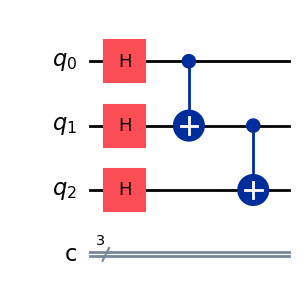

In [144]:
#-----------------------------------------------------------------
# Define the Reference State U_R
#-----------------------------------------------------------------
def reference_state(num_qubits, num_bits):

    #We define the Quantum Circuit
    qc = QuantumCircuit(num_qubits, num_bits)
    #We pply hadamard on all Qubits
    for qubit in range(num_qubits):
        qc.h(qubit)
    #We create some Entanglement 
    for qubit in range(num_qubits - 1):
        qc.cx(qubit, qubit + 1)
    return qc

reference_state(3,3).draw('mpl')

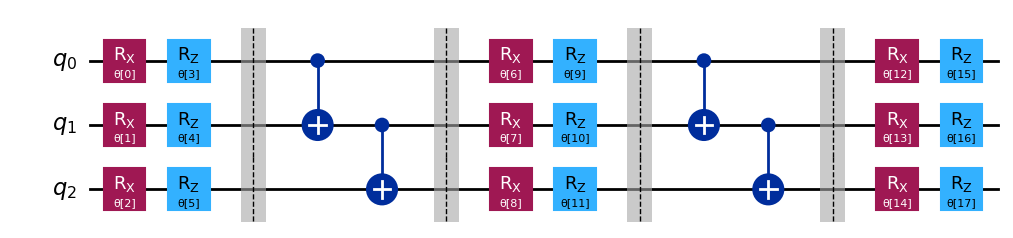

In [145]:
#-----------------------------------------------------------------
# Define the Variational Ansatz U_V - we seperate it because U_V is parameterized circuit used for optimization
#-----------------------------------------------------------------
def ansatz(num_qubits):
    #We define the ansatz
    ansatz = TwoLocal(
                    num_qubits=num_qubits,
                    rotation_blocks=["rx", "rz"],
                    entanglement_blocks="cx",
                    entanglement="linear",
                    reps=2,
                    insert_barriers=True,
                    )
    return ansatz

ansatz(3).decompose().draw('mpl')
#Desine de hamiltonian to be used for the cost function


In [146]:
#-----------------------------------------------------------------
# Define the Cost Function = Cost
#-----------------------------------------------------------------
def cost_function(params, circuit, hamiltonian, estimator):
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost


observable = SparsePauliOp.from_list([
    ("XXI", 1),  # Apply XX on qubits 0 and 1, I on qubit 2
    ("YYI", -3), # Apply YY on qubits 0 and 1, I on qubit 2
    ("IZZ", 2),  # Apply I on qubit 0, ZZ on qubits 1 and 2
])
print(observable)
estimator = StatevectorEstimator()
theta_list = (2 * np.pi * np.random.rand(ansatz(3).num_parameters)).tolist()

cost = cost_function(theta_list,ansatz(3),observable,estimator)

print("Observable:", observable)
print("Cost function value:", cost)

SparsePauliOp(['XXI', 'YYI', 'IZZ'],
              coeffs=[ 1.+0.j, -3.+0.j,  2.+0.j])
Observable: SparsePauliOp(['XXI', 'YYI', 'IZZ'],
              coeffs=[ 1.+0.j, -3.+0.j,  2.+0.j])
Cost function value: -1.2159017308587303


In [147]:
#-----------------------------------------------------------------
# Define the Classical Optimization loop
#-----------------------------------------------------------------
import time

def optimization(num_qubits):
    circuit = ansatz(num_qubits)
    num_params = len(circuit.parameters)
    x0 = np.ones(num_params)
    start_time = time.time()
    #Use COBYLA optimizer
    optimizer = minimize(cost_function, x0, args=(circuit, observable, estimator), method="COBYLA")
    end_time = time.time()
    execution_time = end_time - start_time
    return optimizer.x
    
print(optimization(3))

[0.64700626 0.30215326 1.38691314 2.54158614 0.40092717 0.76546413
 0.99661527 1.57051648 1.82402554 2.62677267 1.57109126 1.56916837
 1.06100779 0.82127056 1.57064823 2.25782732 1.43438282 1.15559339]


In [148]:
#-----------------------------------------------------------------
# Connect with personal token and search for a backend
#-----------------------------------------------------------------
QiskitRuntimeService.save_account(

    channel="ibm_quantum",

    token="d01921c8905660b4853afbc6b3402147808e60866adea464c59a02b9ac0aaaaab9efb7bffc82b27c31d82406f4ee6ab59686880c812f2c731c078bacfdfe6802",

    set_as_default=True,

    overwrite=True,
)

service = QiskitRuntimeService()

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127) #service.backend("ibm_brisbane") #service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_brisbane'

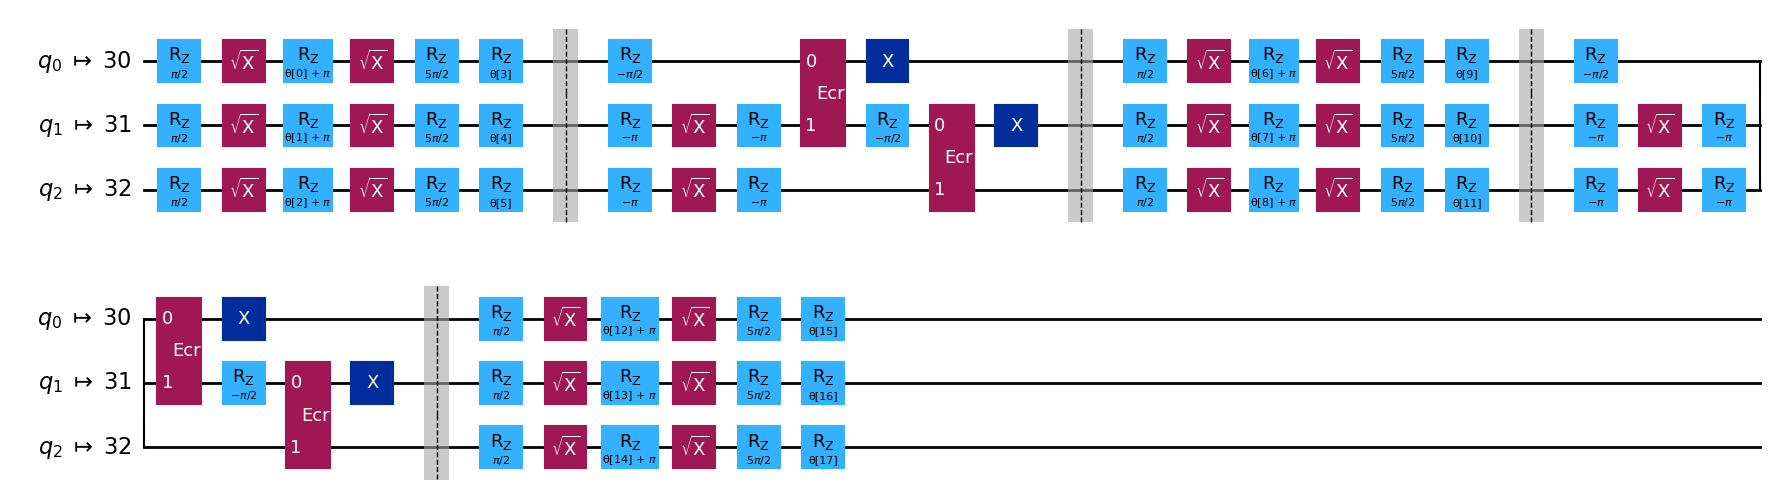

In [149]:
#-----------------------------------------------------------------
# Build the isa_circuit for the backend above
#-----------------------------------------------------------------
ansatz_circuit = ansatz(3)
expected_parameters = ansatz_circuit.parameters

optimal_params = optimization(3)
optimal_qc = ansatz_circuit.assign_parameters(optimal_params)

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

#We transform our circuit into an ISA Circuit to make it backend compatible
isa_circuit = pm.run(ansatz_circuit)
isa_observable = observable.apply_layout(layout = isa_circuit.layout)

#Display the new isa_circuit
isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")






In [ ]:
#-----------------------------------------------------------------
# Run Circuit on Real QC
#-----------------------------------------------------------------
from qiskit.visualization import plot_histogram
#!!!!!!!!!!!!!!UNCOMMENT THIS AT FIRST RUN!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!COMMENT AT SECOND RUN!!!!!!!!!!!!!!
estimator = Estimator(backend=backend)
job = estimator.run([(isa_circuit, isa_observable, theta_list)])
#print(job)

#!!!!!!!!!!!!!!COMMENT THIS AT FIRST RUN!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!UNCOMMENT THIS AT SECOND RUN AND TAKE JOB FROM BELLOW AND ADD IN JOB_ID!!!!!!!!!!
#job_id = 'cwzzr4gz326g008qqdcg'
#job = service.job(job_id)

#Get the probabilies
probs = job.result()[0]
#print(dir(job))


#print("Attributes of probs.data:", dir(probs.data.evs))
#print("Content of probs.data:", probs.data.evs)

#counts_sampler = probs.data.evs
#plot_histogram(counts_sampler)
#PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})





In [140]:
#-----------------------------------------------------------------
# Final Results - calculate best channel
#-----------------------------------------------------------------
optimal_index = np.argmax(probs) % len(channels)
optimal_channel = channels[optimal_index]
print("Available Channels:", available_channels)
print("Measured SNR:", measured_snr)
print("Optimal Channel Selected:", optimal_channel)

Available Channels: [201, 139, 302, 422, 78, 379, 39, 40, 59, 437]
Measured SNR: [2, 6, 0, 6, 7, 6, 5, 4, 6, 1]
Optimal Channel Selected: {'id': 'ch1', 'channel_code': 201, 'snr': 2, 'interference': 2, 'latency': 6, 'bandwidth': 25000.0}
